In [121]:
# Install dependencies
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

Download the Keras MNIST dataset:
https://keras.io/api/datasets/mnist/

The dataset contains 70,000 grayscale images of handwritten digits (0–9), each of size 28x28 pixels.

Description of the returned structure:
- Tuple of NumPy arrays: (x_train, y_train), (x_test, y_test).
    - x_train: uint8 NumPy array of grayscale image data with shapes (60000, 28, 28), containing the training data. Pixel values range from 0 to 255.
    - y_train: uint8 NumPy array of digit labels (integers in range 0-9) with shape (60000,) for the training data.
    - x_test: uint8 NumPy array of grayscale image data with shapes (10000, 28, 28), containing the test data. Pixel values range from 0 to 255.
    - y_test: uint8 NumPy array of digit labels (integers in range 0-9) with shape (10000,) for the test data.

In [122]:
# Set a seed for static results.
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Load MNIST data and assert size and shape.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

We want to normalize our input data. This is required because we have values from 0-255 and we want values between 0-1.

We use the value `255.0` here to return an array of decimals. Using the value `255` may be interpretted as an integer, and we would end up doing integer division. The resulting value would be `0` for values less than 255 and `1` for values equallying 255.

As an aside, we only have a single "color" here because the MNIST dataset is greyscale. The MNIST dataset is effectively the "hello world" of machine learning. If we were working in full RGB color, we would have three input signals per pixel. This bloats the number of inputs per instance from 784 to 2352. This is avoided because it introduces complexity and increases training time. We can work with more complicated datasets later.

In [123]:
x_train, x_test = x_train / 255.0, x_test / 255.0

Now we can label our data.

Because we are working with output values from 0 to 9, we have 10 total potential outcomes. We can use the utility `to_categorical` method for binary classification. In other words, we're saying we have two choices if a given input matrix matches each of the 10 labeled outcomes -- `true` or `false`.

Read More: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

Using a sample from this page:
```
a = keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)
print(a)
```

Result:
```
[[1, 0, 0, 0,]
 [0, 1, 0, 0,]
 [0, 0, 1, 0,]
 [0, 0, 0, 1,]]
```

The result array contains 4 entries to match the `num_classes` parameter. The `to_categorical()` call counts from 0 to 3 and labels the input based on if the entry value (indexes in this case) matches the category value (incrementing counter value in this case).

This type of encoding is called [one-hot encoding](https://www.geeksforgeeks.org/ml-one-hot-encoding/). It's less of a risk in this simple example, but in more complex models, order matters. If we left our categories as 0 through 9, we run the risk of biasing toward larger (or smaller) outputs based on the order the model sees its training data.

In [124]:
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10) 

print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

y_train shape: (60000, 10), y_test shape: (10000, 10)


Now we can build the neural network.

We use `Sequential` here because we expect unidirectional data flow (or in other words, no recursion, no branching, etc). Here's a description of the network's three layers:
1. The first layer matches the shape of our input. In this case, 28 x 28 matrix of decimal values ranging from 0 to 1.
2. The second layer is a dense hidden layer of 128 nodes -- activated by the ReLU function. 
   1. Why 128? Choosing the right hidden layer size (or count) can be explored in future experiments. Just note that more neurons will generally take longer to train but **MAY** lead to better outputs.
   2. Why ReLU? ReLU (or rectified linear unit) is a non-linear activation function that returns 0 for negative values. It returns N for all N >= 0. It's generally used in binary on-off classification problems. We can look non-binary classification problems in future experiements.
   3. Why only one hidden layer? Because this is a relatively simple problem. Imagine each layer learning a combination of factors from the previous layer. In a photograph classification problem (e.g. is this full-color image a dog?), we'd start with a hidden layer of the colors beginning to recognize lines and shapes. We could add another hidden layer to turn those lines and shapes into textures. Those textures could feed an additional hidden layer, which could recognize fur, eyes, paws, tails, etc. With enough of those structures in the right size, shape, and color, the final output will give a percent certainty that the given image is of a dog.
   4. Why is it dense? Because each input is connected to each output, and each output is connected to each input. There are neural networks where we don't want each layer densely connected. Those will be seen in later experiments.
3. The third layer is the output of 10 values. These are our 10 potential categories of 0 through 9.
   1. Why softmax? Softmax sums our 10 outputs and turns them into percentages of this summed value. Each number represents the "certainty" the model has for the given input matching the given output. This provides the relative percent "chance" of a given input mapping to the output categories.
   
For our scenario, we could add 100 hidden layers if we wanted. It would increase the time it takes to train for no real gain (or potentially even a loss). Rightsizing the size and shape of neural network requires experimentation.

In [125]:
model = Sequential([
    Input(shape=(28, 28)),
    Flatten(),    
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Now we're ready to train and evaluate.

In [126]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32,  validation_data=(x_test, y_test), verbose=1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8854 - loss: 0.4167 - val_accuracy: 0.9620 - val_loss: 0.1317
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9631 - loss: 0.1271 - val_accuracy: 0.9701 - val_loss: 0.0976
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9757 - loss: 0.0851 - val_accuracy: 0.9735 - val_loss: 0.0853
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9824 - loss: 0.0617 - val_accuracy: 0.9745 - val_loss: 0.0811
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9873 - loss: 0.0460 - val_accuracy: 0.9745 - val_loss: 0.0803
313/313 - 0s - 840us/step - accuracy: 0.9745 - loss: 0.0803
Test accuracy: 0.97


Our model has reached above 97% accuracy for unseen test data. This can be raised further through:
1. Adjusting the architecture (e.g. more hidden layers, more nodes per layer).
2. Longer training (i.e. run more epochs).

Now, let's visualize our results.

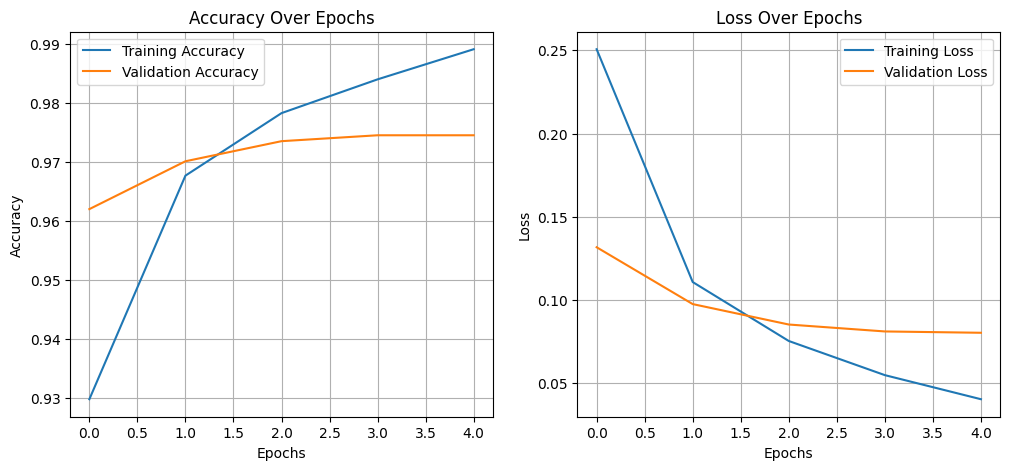

In [127]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()